In [1]:
import numpy as np
from timeit import timeit as timeit
import os
import matplotlib.pyplot as plt
import subprocess
from joblib import Parallel, delayed
import multiprocessing

Ici on convertit une matrice SNP en SMC. Dans ces deux fonctions on va juste gérer les colonnes ( données )

In [2]:
def SNPtoSMC(dist, SNP, POS):
    """
    dist : id de l'individu distingué
    SNP : matrice de SNPs
    POS : postions de la matrice de SNPs
    return : une matrice au format SMC
    """
    N = SNP.shape[0]
    N = N if N%2 == 0 else N - 1
    assert dist < N/2
    
    dist *= 2
    M = POS.shape[0]
    SMC = np.zeros((2*M,4), dtype=int)
    SMC[:,-1] = N*np.ones(2*M, dtype=int) - 2
    SMC[:, 0] = np.ones(2*M, dtype=int)
    d = SNP[dist, :] + SNP[dist+1, :]
    u = np.sum(SNP, axis=0, dtype=int) - d
    SMC[1::2, 1:-1] = np.transpose([d, u]) 
    SMC[0::2, 0:-1] = np.transpose([POS - 1, np.zeros(M, dtype=int), np.zeros(M, dtype=int)])
    todelete = np.argwhere(POS <= 1).transpose()*2
    return np.delete(SMC, todelete, 0)

Ici on crée cette fonction pour corriger le bug des 0 dans les données

In [3]:
def loadfile(scenario, i):
    file_name = "hdgp/scenario_" + scenario +"/hdgp_" + scenario + "_" + str(i) + ".npz"
    data = np.load(file_name)
    return data

On crée une fonction pour crée le header du format smc

In [4]:
def header_smc(pid, dist, n_ind):
    """
    pid: id de la population considérée
    dist: individu distingué
    n_ind: nombre d'individus
    return: le header correspondant pour le format SMC
    """
    header = 'SMC++ {"version": "1.15.4.dev18+gca077da", "pids": ["'+ pid +'"], "undist": [['
    for i in range(n_ind):
        if(i != dist):
            indid = pid + str(i)
            header += '["' + indid + '", 0], ["' + indid + '", 1], '
    indid = pid + str(dist)
    header = header[:-2] + ']], "dist": [[["' + indid +'", 0], ["' + indid + '", 1]]]}'
    return header

In [5]:
## test sur un exemple simple
def test():
    snp = np.array([
    [0, 0, 1, 1],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    ])
    pos = np.array([3, 5, 1, 10])
    print(SNPtoSMC(0, snp, pos))
    print(SNPtoSMC(1, snp, pos))
    print(SNPtoSMC(2, snp, pos))
test()

[[2 0 0 4]
 [1 0 2 4]
 [4 0 0 4]
 [1 0 1 4]
 [1 1 0 4]
 [9 0 0 4]
 [1 2 1 4]]
[[2 0 0 4]
 [1 2 0 4]
 [4 0 0 4]
 [1 0 1 4]
 [1 0 1 4]
 [9 0 0 4]
 [1 0 3 4]]
[[2 0 0 4]
 [1 0 2 4]
 [4 0 0 4]
 [1 1 0 4]
 [1 0 1 4]
 [9 0 0 4]
 [1 1 2 4]]


In [6]:
## mesure du temps prise par la fonction SNPtoSMC
n = 1000
data = loadfile(scenario="16844", i="5")
SMC = SNPtoSMC(0, data['SNP'], data['POS'])
print(SMC[:10])
time = timeit("SNPtoSMC(0, data['SNP'], data['POS'])", globals=globals(), number=n)/n
print(f"\nSNPtoSMC exec time {time:.5f}s")

assert SMC[:, 0].any() > 0

[[2328    0    0    8]
 [   1    1    4    8]
 [3344    0    0    8]
 [   1    1    5    8]
 [ 183    0    0    8]
 [   1    1    5    8]
 [2579    0    0    8]
 [   1    1    5    8]
 [  28    0    0    8]
 [   1    0    3    8]]

SNPtoSMC exec time 0.00075s


La première fonction sert à générer tous les fichiers SMC pour toutes données.
Alors que la seconde fonction c'est juste pour un scénario en particulier

In [7]:
def one_scenario(d="scenario_11687", save_dir="smc_files"):
    if save_dir not in os.listdir():
        os.mkdir(save_dir)
    for file in os.listdir("hdgp/" + d):
        # chargement des données
        data = np.load("hdgp/" + d + "/" + file)
        SNP, POS = data['SNP'], data['POS']
        # remplace tous les 0 de la matrice de positions par des 1
        POS[POS == 0] = 1 
        # on récupère le nombre d'individus (on le suppose pair)
        N = data['SNP'].shape[0]
        N = N if N%2 == 0 else N - 1
        # création du dossier du scénario
        scenario_dir = save_dir + "/" + d
        if d not in os.listdir(save_dir):
            os.mkdir(scenario_dir)
            
        for dist in range(0, int(N/2)):
            # pour chaque individu distingué, on crée un dossier qui contient les fichiers smc associés
            dist_dir = scenario_dir + "/" + "dist_" + str(dist)
            if "dist_" + str(dist) not in os.listdir(scenario_dir):
                os.mkdir(dist_dir)
            SMC = SNPtoSMC(dist, SNP, POS)
            filename = dist_dir + "/" + file + str(dist) + ".smc"
            header = header_smc("hdgp", dist, N)
            np.savetxt(filename , SMC, delimiter=' ', fmt = "%d", header=header)
            
def all_scenarios(multi_thread=False):
    if(multi_thread):
        num_cores = multiprocessing.cpu_count()
        Parallel(n_jobs=num_cores)(delayed(one_scenario)(d) for d in os.listdir("hdgp"))
    else:
        for d in os.listdir("hdgp"):
            one_scenario(d)

In [8]:
n = 3
time = timeit('one_scenario("scenario_6")', globals=globals(), number=n)/n
print(f"{time:.2f}s pour convertir tous les fichiers du scénario 6")
n = 1
time = timeit("all_scenarios(True)", globals=globals(), number=n)/n
print(f"{time:.2f}s pour convertir tous les scénarios")

28.86s pour convertir tous les fichiers du scénario 6
717.14s pour convertir tous les scénarios


In [9]:
def run_smc_estimate(scenario, out_dir="out", display=False):
    scenario_dir = f"smc_files/{scenario}"
    scenario_out_dir = f"{out_dir}/{scenario}"
    if out_dir not in os.listdir():
        os.mkdir(out_dir)
    if scenario not in os.listdir(out_dir):
        os.mkdir(scenario_out_dir)
    for dist in os.listdir(scenario_dir):
        scenario_out_dist_dir = f"{scenario_out_dir}/{dist}"
        if dist not in os.listdir(scenario_out_dir):
            os.mkdir(scenario_out_dist_dir)
        command_estimate = f'smc++ estimate 1.45e-08 --knots 22 -w 2000000 --timepoints 0 34483 -o {scenario_out_dist_dir} {scenario_dir}/{dist}/*.smc' # il faut enlever l'option -w
        command_estimate = f'smc++ estimate 1.45e-08 --knots 22 -w 2000000 --timepoints 0 34483 -o {scenario_out_dist_dir} {scenario_dir}/{dist}/*.smc' # il faut enlever l'option -w
        command_plot = 'smc++ plot '
        print(f"running : {command_smc_estimate}")
        process = subprocess.Popen(command_estimate, shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
        stdout, stderr = process.communicate()
        if(display):
            print(stdout, stderr)
        
        
n = 1
time = timeit('run_smc_estimate("scenario_11687", display=False)', globals=globals(), number=n)/n
print(f"{time:.2f}s smc")

running : smc++ estimate 1.45e-08 --knots 22 -w 2000000 --timepoints 0 34483 -o out/scenario_11687/dist_5 smc_files/scenario_11687/dist_5/*.smc
running : smc++ estimate 1.45e-08 --knots 22 -w 2000000 --timepoints 0 34483 -o out/scenario_11687/dist_3 smc_files/scenario_11687/dist_3/*.smc
running : smc++ estimate 1.45e-08 --knots 22 -w 2000000 --timepoints 0 34483 -o out/scenario_11687/dist_0 smc_files/scenario_11687/dist_0/*.smc
running : smc++ estimate 1.45e-08 --knots 22 -w 2000000 --timepoints 0 34483 -o out/scenario_11687/dist_4 smc_files/scenario_11687/dist_4/*.smc
running : smc++ estimate 1.45e-08 --knots 22 -w 2000000 --timepoints 0 34483 -o out/scenario_11687/dist_1 smc_files/scenario_11687/dist_1/*.smc
running : smc++ estimate 1.45e-08 --knots 22 -w 2000000 --timepoints 0 34483 -o out/scenario_11687/dist_2 smc_files/scenario_11687/dist_2/*.smc
552.46s smc


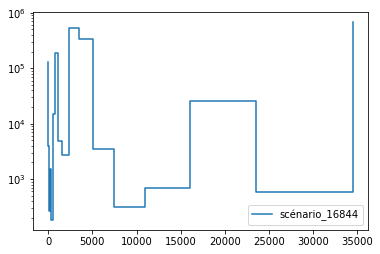

In [10]:
def plot_deep_learning_results(i):
    """
    i : numéro du scénario
    """
    fig, ax = plt.subplots(1, 1)
    results_deep = np.genfromtxt('hdgp_demo_parameters_subsample.csv',delimiter=',', dtype=int)
    X = results_deep[1,6:27]
    ids = np.argwhere(results_deep[:,0] == i)
    Y = results_deep[ids,27:].flatten()
    X2 = np.zeros(2*X.size, dtype=int)
    Y2 = np.zeros(2*Y.size, dtype=int)
    X2[1::2], X2[::2] = X, X
    Y2[1::2], Y2[::2] = Y, Y
    X2 = X2[1:]
    Y2 = Y2[:-1]
    ax.plot(X2, Y2, label=f"scénario_{i}")
    ax.set_yscale('log')
    ax.legend()
    
plot_deep_learning_results(16844)